In [1]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(5):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)
    if os.path.basename(module_path) =='roofline':
        break

In [2]:
from src import decode_moddeling
import pandas as pd
from plotnine import *
import plotnine as p9
from src.system import System
from src.unit import Unit
from variables import *

/Users/abambhaniya3/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# This will reload the imported modules (e.g. get_decode_model_characterstics) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2   

In [4]:
Model_list = [ 'LLaMA_70b']
Model_names_in_plot = [  'LLaMA3-70B'] ## Only to be used for plot


## Batch scaling for various models

In [5]:
data = []

for model in Model_list:
        for num_cores in [2,4]:
                for batch_size in [1,2,3,4,5,6,7,8,12,16,20,24,28,32,36,40,44,48]:
                        decode_outputs_model = decode_moddeling(model = model, batch_size = batch_size, Bb = 4 ,
                                        input_tokens = 8000, output_tokens = 256, FLAT = True,
                                        system_name = 'A100-40GB', bits='int8',
                                        tensor_parallel = num_cores, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=True) 
                        data.append([model, num_cores, batch_size, decode_outputs_model['Latency'], decode_outputs_model['Throughput'], decode_outputs_model['is_offload']] + decode_outputs_model['Runtime_breakdown'])
                        # except ValueError:
                        #         pass

                
data_df = pd.DataFrame(data, columns = ['Model', '# Devices','Batch', 'Latency(s)', 'Tokens/s', 'Offloaded', 'GEMM time', 'SA time', 'Comm. time'])


/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:110: UserWarning: Some Parameter offloaded, effective Memory BW:128.1192917054986 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:110: UserWarning: Some Parameter offloaded, effective Memory BW:128.11252747252746 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:110: UserWarning: Some Parameter offloaded, effective Memory BW:128.10648918469218 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:110: UserWarning: Some Parameter offloaded, effective Memory BW:128.10106592972758 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:110: UserWarning: Some Parameter offloaded, effective Memory BW:128.0961682945154 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/G

In [6]:
data_df = data_df.replace(Model_list, Model_names_in_plot)
data_df['# Devices'] = data_df['# Devices'].astype(str)
data_df['Batch'] = data_df['Batch'].astype(int)
data_df['Offloaded'] = data_df['Offloaded'].astype(str)
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot)
data_df = data_df.replace(['True','False'], ['-Offloaded', ''])
data_df['Label'] = data_df['# Devices'] + data_df['Offloaded']


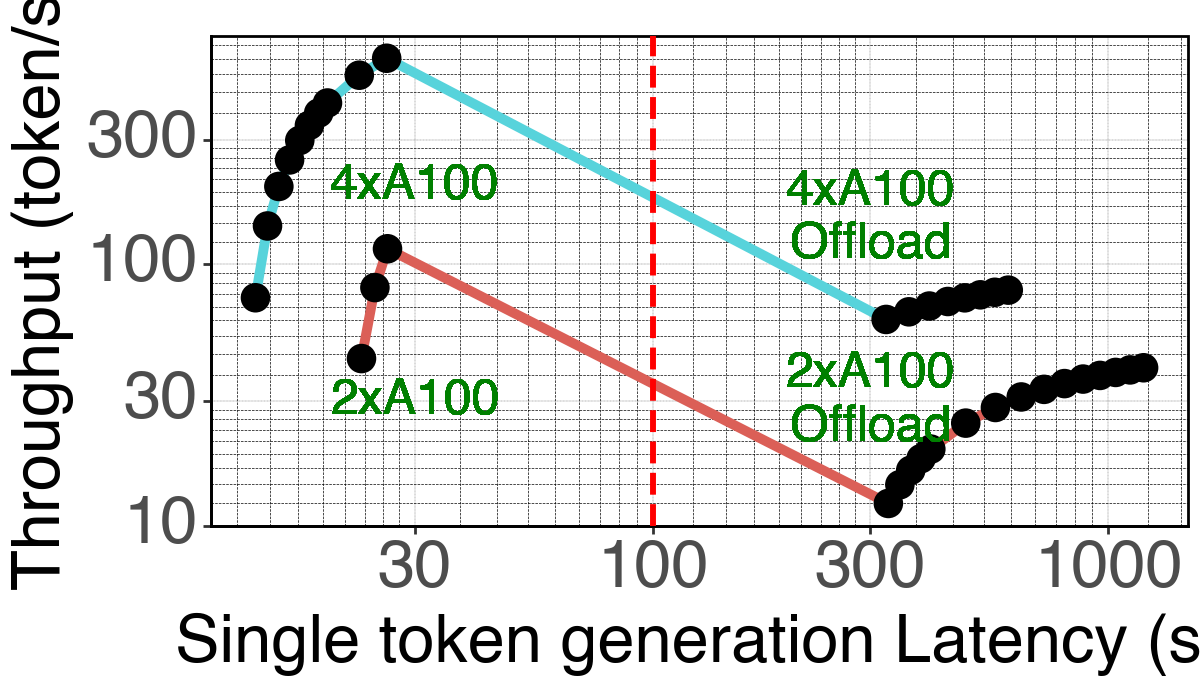

In [8]:

vline_data = pd.DataFrame({
    'xintercept': [ 100],  # x-values where you want to draw the lines
    'Model': Model_names_in_plot,  # Corresponding facets
})
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot, ordered=True)
vline_data['Model'] = pd.Categorical(vline_data['Model'], categories=Model_names_in_plot, ordered=True)

p1 = (
    p9.ggplot(data_df, p9.aes(x='Latency(s)', y='Tokens/s', label='Label'))
    + p9.geom_line(p9.aes(color='# Devices'),size=2) # line plot
    + p9.geom_point(p9.aes(),size=5) # line plot

    + p9.labs(x='Single token generation Latency (s)', y='Throughput (token/s)')
    + plot_theme
    + p9.theme(panel_grid_minor=p9.element_line(color='black', size=0.0, linetype='dashed'),panel_grid_major=p9.element_line(color='black', size=0.1, linetype='dashed'),)
    + p9.scale_x_log10()
    + p9.scale_y_log10()
    + p9.geom_vline(aes(xintercept='xintercept'), data=vline_data, linetype='dashed', color='red', size=1.2)
    + scale_color_discrete(guide=False)
    + p9.theme(figure_size=(6,3.5))  
    + p9.geom_text(p9.aes(x=30, y=30), color='green', label='2xA100', size=18)  # Label
    + p9.geom_text(p9.aes(x=30, y=200), color='green', label='4xA100', size=18)  # Label 

    + p9.geom_text(p9.aes(x=300, y=30), color='green', label='2xA100\nOffload', size=18)  # Label 
    + p9.geom_text(p9.aes(x=300, y=150), color='green', label='4xA100\nOffload', size=18)  # Label       
)   
print(p1)
